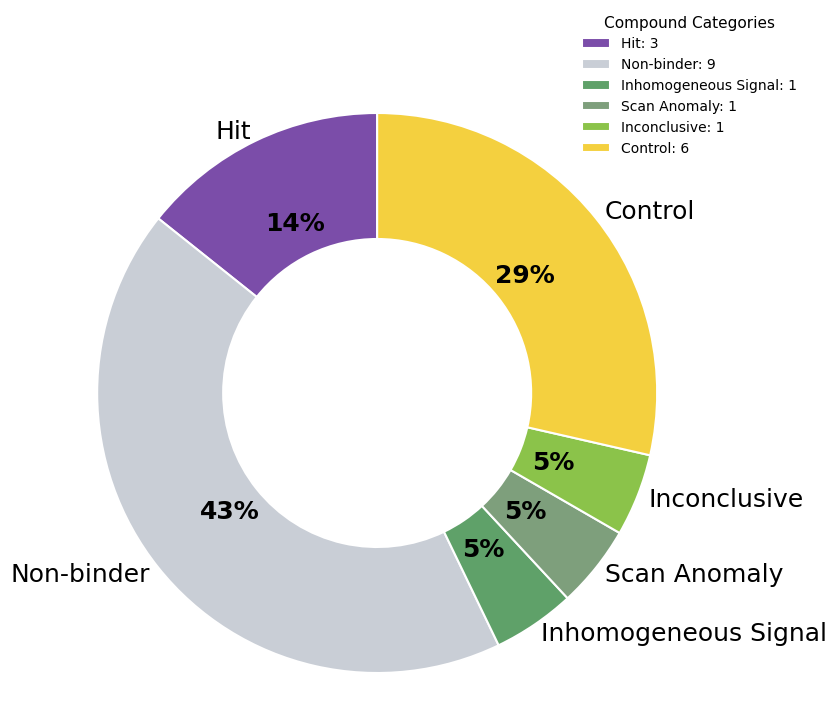

In [3]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
os.chdir(ROOT)

DATA_SCR = Path("synthetic-data") / "screening"
OUT_SCR_FIG = Path("outputs") / "screening" / "figures"
OUT_SCR_FIG.mkdir(parents=True, exist_ok=True)

file1 = DATA_SCR / "first screening overview.xlsx"
file2 = DATA_SCR / "second screening overview.xlsx"
file3 = DATA_SCR / "third screening overview.xlsx"

def extract_ligand_categories(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out = out[out["Ligand Information"].notna()]
    out = out[out["Ligand Information"] != "Name"]
    out = out[~out["Ligand Information"].astype(str).str.contains("Data Point", na=False)]
    out = out.rename(columns={"Ligand Information": "Ligand", "Analysis Results": "Category"})
    out["Category"] = out["Category"].astype(str).str.strip()
    return out[["Ligand", "Category"]].dropna(subset=["Category"])

df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)
df3 = pd.read_excel(file3)

lig_all = pd.concat(
    [extract_ligand_categories(df1),
     extract_ligand_categories(df2),
     extract_ligand_categories(df3)],
    ignore_index=True
)

order = ["Hit", "Non-binder", "Inhomogeneous Signal", "Scan Anomaly", "Inconclusive", "Aggregation", "Control"]
counts = lig_all["Category"].value_counts()
counts = counts.reindex(order).dropna().astype(int)

colors = {
    "Hit": "#7B4DA9",
    "Non-binder": "#C9CED6",
    "Inhomogeneous Signal": "#5FA169",
    "Scan Anomaly": "#7E9F7C",
    "Inconclusive": "#8BC34A",
    "Aggregation": "#E57373",
    "Control": "#F4D03F"
}

inner_r = 0.45
ring_w = 0.45
mid_r = inner_r + ring_w / 2

fig, ax = plt.subplots(figsize=(9, 8))
wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=counts.index,
    autopct="%1.0f%%",
    startangle=90,
    pctdistance=mid_r,
    labeldistance=1.04,
    colors=[colors[c] for c in counts.index],
    wedgeprops=dict(width=ring_w, edgecolor="white", linewidth=1.5),
    textprops=dict(color="black", fontsize=18),
)

ax.add_artist(plt.Circle((0, 0), inner_r, fc="white"))
ax.axis("equal")

for t in autotexts:
    t.set_fontsize(18)
    t.set_weight("bold")

legend_labels = [f"{cat}: {cnt}" for cat, cnt in zip(counts.index, counts.values)]
legend_labels.append(f"Total: {counts.sum()}")

ax.legend(
    wedges,
    legend_labels,
    title="Compound Categories",
    loc="right",
    bbox_to_anchor=(1.12, 1.0),
    fontsize=10,
    title_fontsize=11,
    frameon=False
)

plt.savefig(OUT_SCR_FIG / "ligand_cake_plot_thick.png", dpi=300, bbox_inches="tight")
plt.savefig(OUT_SCR_FIG / "ligand_cake_plot_thick.pdf", dpi=300, bbox_inches="tight")
plt.show()